In [1]:
#%pip install talipp

In [167]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib
from sklearn.preprocessing import MinMaxScaler
import requests
from requests_html import HTMLSession
from sklearn.model_selection import train_test_split
import pywt
from talipp.indicators import BOP
from talipp.ohlcv import OHLCVFactory

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2
    TAKE = 3

In [4]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers=ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [5]:
def calculate_percentage_increase(final_value, starting_value):
    try:
        return 100 * ((final_value - starting_value) / starting_value)
    except:
        print(final_value, starting_value)

In [6]:
def ssl_indicator(df):
    sma_high = talib.SMA(df['high'], 10)
    sma_low = talib.SMA(df['low'], 10)
    hlv = [np.nan]
    for i in range(0, len(df['close'])):
        if df['close'][i] > sma_high[i]:
            hlv.append(1)
        elif df['close'][i] < sma_low[i]:
            hlv.append(-1)
        else:
            hlv.append(hlv[i-1])

    ssl_down = [sma_high[i] if hlv[i] < 0 else sma_low[i] for i in range(len(df.close))]
    ssl_up = [sma_low[i] if hlv[i] < 0 else sma_high[i] for i in range(len(df.close))]

    signals = []
    for i in range(0, len(df.close)):
        if ssl_up[i-1] < ssl_down[i-1] and ssl_up[i] > ssl_down[i]:
            signals.append(Positions.LONG)
        elif ssl_up[i-1] > ssl_down[i-1] and ssl_up[i] < ssl_down[i]:
            signals.append(Positions.SHORT)
        else:
            signals.append(Positions.HOLD)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [7]:
def bbands_indicator(df):
    upper_bband_indicator, _, lower_bband_indicator = talib.BBANDS(df["close"], timeperiod=20)

    signals = []
    for i in range(0, len(df.close)):
        if upper_bband_indicator[i] < df['close'][i]:
            signals.append(Positions.SHORT)
        elif lower_bband_indicator[i] > df['close'][i]:
            signals.append(Positions.LONG)
        else:
            signals.append(Positions.HOLD)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [8]:
def wavetrend_indicator(df):
    ap = (df['high'] + df['low'] + df['close']) / 3
    esa = talib.EMA(ap, 10)
    d = talib.EMA(np.abs(ap - esa), 10)
    ci = (ap - esa) / (0.015 * d)
    tci = talib.EMA(ci, 21)

    signals = []
    for i in range(0, len(tci)):
        if tci[i] > 60:
            signals.append(Positions.SHORT)
        elif tci[i] < -60:
            signals.append(Positions.LONG)
        else:
            signals.append(Positions.HOLD)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [9]:
def supertrend_indicator(df, atr_period, multiplier):
    
    high = df['high']
    low = df['low']
    close = df['close']
    
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    hl2 = (high + low) / 2
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        else:
            supertrend[curr] = supertrend[prev]

            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return final_lowerband, final_upperband

In [10]:
def rsi_indicator(df):
    rsi = talib.RSI(df.close, 14)

    signals = []
    for i in range(0, len(rsi)):
        if rsi[i] > 60: # Default value: 70
            signals.append(Positions.SHORT)
        elif rsi[i] < 40: # Default value: 30
            signals.append(Positions.LONG)
        else:
            signals.append(Positions.HOLD)
        
    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [11]:
def swing_detection(index, df):
    sh = []
    sl = []
    start = (index*2) - 1
    for i in range(index-1):
        sh.append(False)
        sl.append(False)
    for ci, row in df.iterrows():
        
        swing_high = False
        swing_low = False
        
        if ci < start:
            continue
        
        swing_point_high = df['high'][ci - index]
        swing_point_low = df['low'][ci - index]
        
        for i in range(0, start):
            swing_high = True
            if i < index:
                if df['high'][ci - i] > swing_point_high:
                    swing_high = False
                    break
            if i > index:
                if df['high'][ci - i] >= swing_point_high:
                    swing_high = False
                    break
            
        for i in range(0, start):
            swing_low = True
            if i < index:
                if df.low[ci - i] < swing_point_low: 
                    swing_low = False
                    break  
            if i > index:
                if df.low[ci - i] <= swing_point_low: 
                    swing_low = False
                    break 
            
        sh.append(swing_high)
        sl.append(swing_low)
        
    for i in range(index):
        sh.append(False)
        sl.append(False)
        
    current_sh = 0
    current_sl = 0
    sh_nums = []
    sl_nums = []
    for i, row in df.iterrows():
        if sh[i] == True:
            current_sh = df.high[i]
        if sl[i] == True:
            current_sl = df.low[i]
        sh_nums.append(current_sh)
        sl_nums.append(current_sl)
    return sh, sl, sh_nums, sl_nums

In [12]:
def produce_prediction(df, window):  
    prediction = (df.shift(window)['close'] <= df['close'])
    
    return prediction.astype(int)

In [13]:
def preprocess_data(df):
    scaler = MinMaxScaler()
    
    mfi_indicator = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
    all_ssl_signals, _, _ = ssl_indicator(df=df)
    all_bbands_signals, _, _ = bbands_indicator(df=df)
    close_b = produce_prediction(df, 1)
    wavetrend_signals, _, _ = wavetrend_indicator(df)
    rsi_signals, _, _ = rsi_indicator(df)
    sh, sl, sh_nums, sl_nums = swing_detection(5, df)
    
    final_lowerband, final_upperband = supertrend_indicator(df, 10, 3)
    fu_modified = [Positions.LONG if not np.isnan(lowerband) else Positions.SHORT for lowerband in final_lowerband]

    df['close_binary'] = close_b
    #df['price_change_percentage'] = calculate_percentage_increase(df['close'], df['close'].shift())
    #df['fpcp'] = df['price_change_percentage'].shift(-1)
    #df['future_price_binary'] = produce_prediction(df, -1)
    #df['mfi'] = mfi_indicator
    #df['ssl_markover'] = all_ssl_signals
    #df['bbands'] = all_bbands_signals
    #df['wavetrend_signals'] = wavetrend_signals
    df['sh_nums'] = sh_nums
    df['sl_nums'] = sl_nums
    df['supertrend'] = fu_modified
    df['rsi_signals'] = rsi_signals
    df = df.drop(columns={"volume", "Adj Close", "open", "high", "low", "date"})
    df = df.dropna()
    
    #df[['mfi', 'price_change_percentage']] = scaler.fit_transform(df[['mfi','price_change_percentage']])
    
    return df

In [14]:
#df = getTickerData('btc-usd', '220d', '1d')
#df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})

In [191]:
session = HTMLSession()
num_currencies=2
#symbols_to_remove = ['USDT-USD', 'USDC-USD', 'BNB-USD', 'XRP-USD', 'DOGE-USD', 'SOL-USD', 'WTRX-USD', 'TRX-USD']
resp = session.get(f"https://finance.yahoo.com/crypto?offset=0&count={num_currencies}")
tables = pd.read_html(resp.html.raw_html)               
df = tables[0].copy()
symbols_yf = df.Symbol.tolist()
#for symbol in symbols_to_remove:
#    print(symbol)
#    symbols_yf.remove(symbol)
print(symbols_yf)

['BTC-USD', 'ETH-USD']


In [192]:
dataframes = []

for symbol in symbols_yf:
    df = getTickerData(symbol, '730d', '1h')
    df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
    dataframes.append(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [193]:
preprocessed_dataframes = []
for df in dataframes:
    p_df = preprocess_data(df)
    if p_df.shape[1] == 6:
        preprocessed_dataframes.append(preprocess_data(df))

In [194]:
training_data = []
testing_data = []
for df in preprocessed_dataframes:
    train, test = train_test_split(df, train_size=0.8, shuffle=False)
    training_data.append(train.dropna())
    testing_data.append(test.dropna())

In [195]:
amount_of_training_rows = 0
amount_of_testing_rows = 0
for df in training_data:
    print(df.shape)
    amount_of_training_rows += df.shape[0]
print(f'total rows of training data - {amount_of_training_rows}')
for df in testing_data:
    print(df.shape)
    amount_of_testing_rows += df.shape[0]
print(f'total rows of testing data - {amount_of_testing_rows}')

(13852, 6)
(13852, 6)
total rows of training data - 27704
(3463, 6)
(3463, 6)
total rows of testing data - 6926


In [196]:
testing_data[0].iloc[0:5]

,close,close_binary,sh_nums,sl_nums,supertrend,rsi_signals
13852,23109.812500,0,23289.976562,23007.072266,0,1
13853,23103.117188,0,23289.976562,23007.072266,0,1
13854,23199.892578,1,23289.976562,23007.072266,0,1
13855,23165.320312,0,23289.976562,23007.072266,0,1
13856,23204.515625,1,23289.976562,23007.072266,0,1


In [69]:
training_data[0].shape[0]

13845

In [32]:
#for i in range(0, len(preprocessed_dataframes)):
#    if 0 in preprocessed_dataframes[i]['close']:
#        print(True)
#        print(i)

In [ ]:
dj = getTickerData('HEX-USD', '730d', '1h')
dj = dj.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
dc = preprocess_data(dj)
dc

[*********************100%***********************]  1 of 1 completed


,close,close_binary,price_change_percentage,mfi,ssl_markover,bbands,wavetrend_signals,supertrend,rsi_signals
14,0.084081,1,0.589101,36.299522,2,2,2,1,2
15,0.084747,1,0.791141,40.490196,1,2,2,1,2
16,0.084359,0,-0.457260,41.453425,2,2,2,1,2
17,0.084487,1,0.151398,49.894628,2,2,2,1,2
18,0.084411,0,-0.089544,55.258717,2,2,2,1,2
...,...,...,...,...,...,...,...,...,...
17301,0.008498,1,0.395551,52.075831,0,2,2,1,2
17302,0.008430,0,-0.805025,66.259159,2,2,2,1,2
17303,0.008320,0,-1.307847,63.307439,2,2,2,0,2
17304,0.008366,1,0.555388,65.721162,2,2,2,0,2


In [ ]:
#pcp = training_data[10][['price_change_percentage']]
pcp = dc[['price_change_percentage']]

17292
(17292, 1)


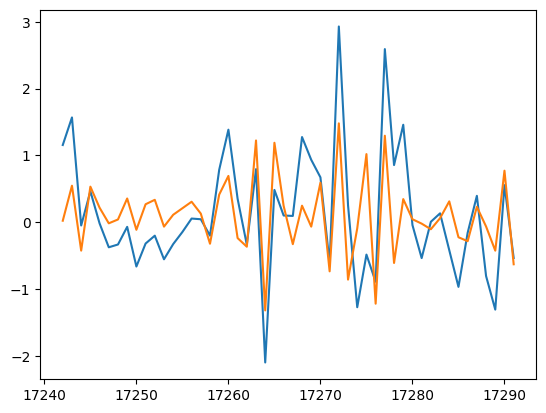

In [15]:
coeffs = pywt.wavedec(pcp['price_change_percentage'].to_numpy(), 'sym5', mode='symmetric')
for i in range(5):
    coeffs[i+5] = np.zeros(coeffs[i+5].shape)
y_rec = pywt.waverec(coeffs, 'sym5', mode='symmetric')
n = 50
print(len(y_rec))
print(pcp.shape)
plt.plot(range(pcp.shape[0]-n, pcp.shape[0]),pcp[-n:])
plt.plot(range(len(y_rec)-n, len(y_rec)),y_rec[-n:])

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

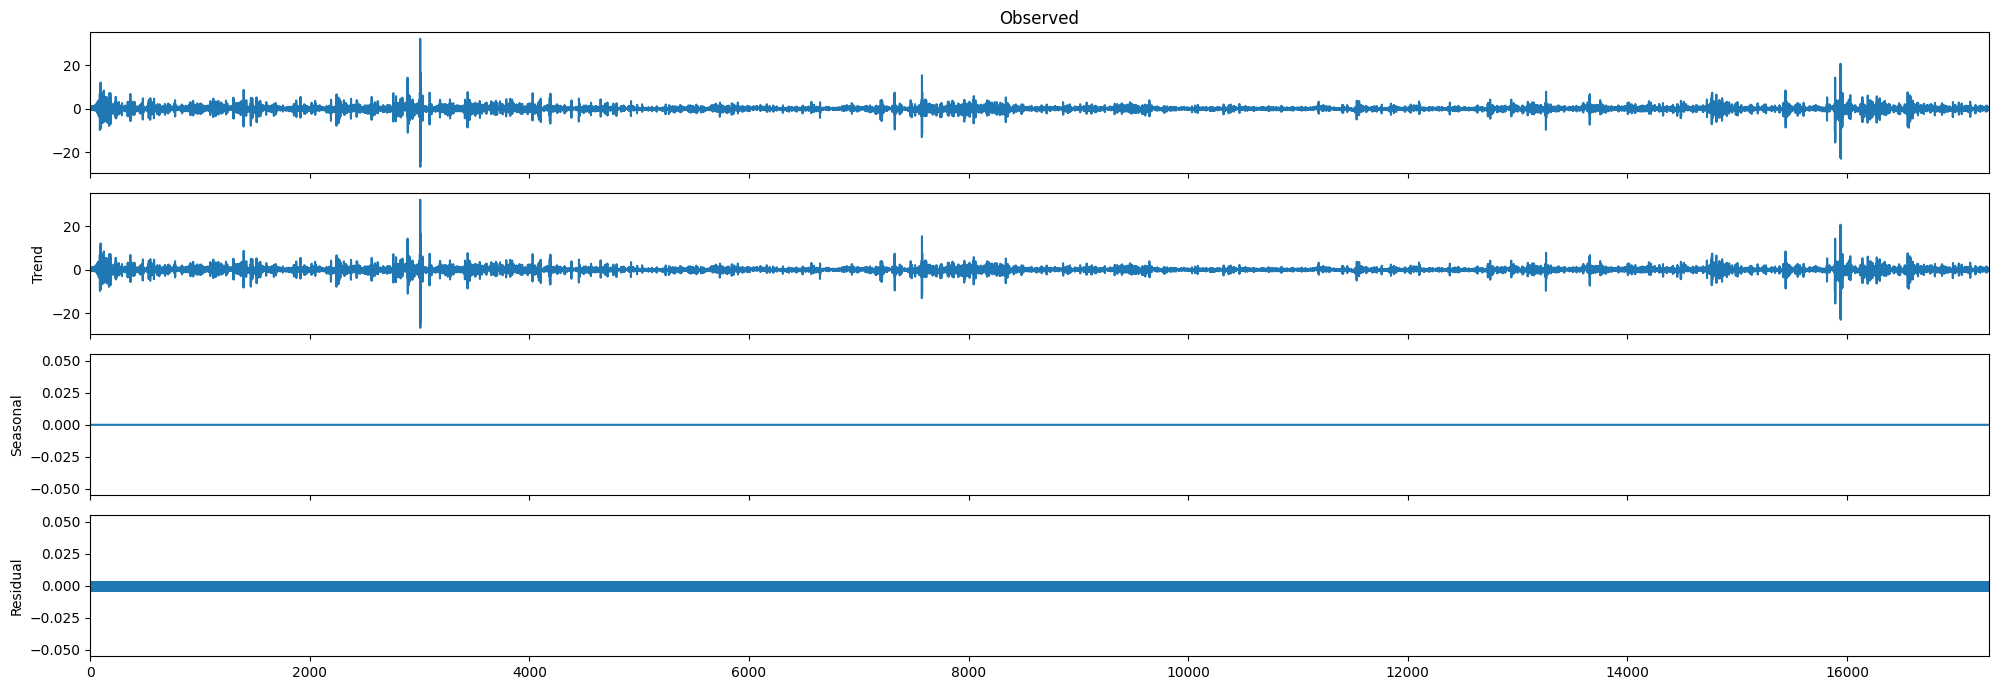

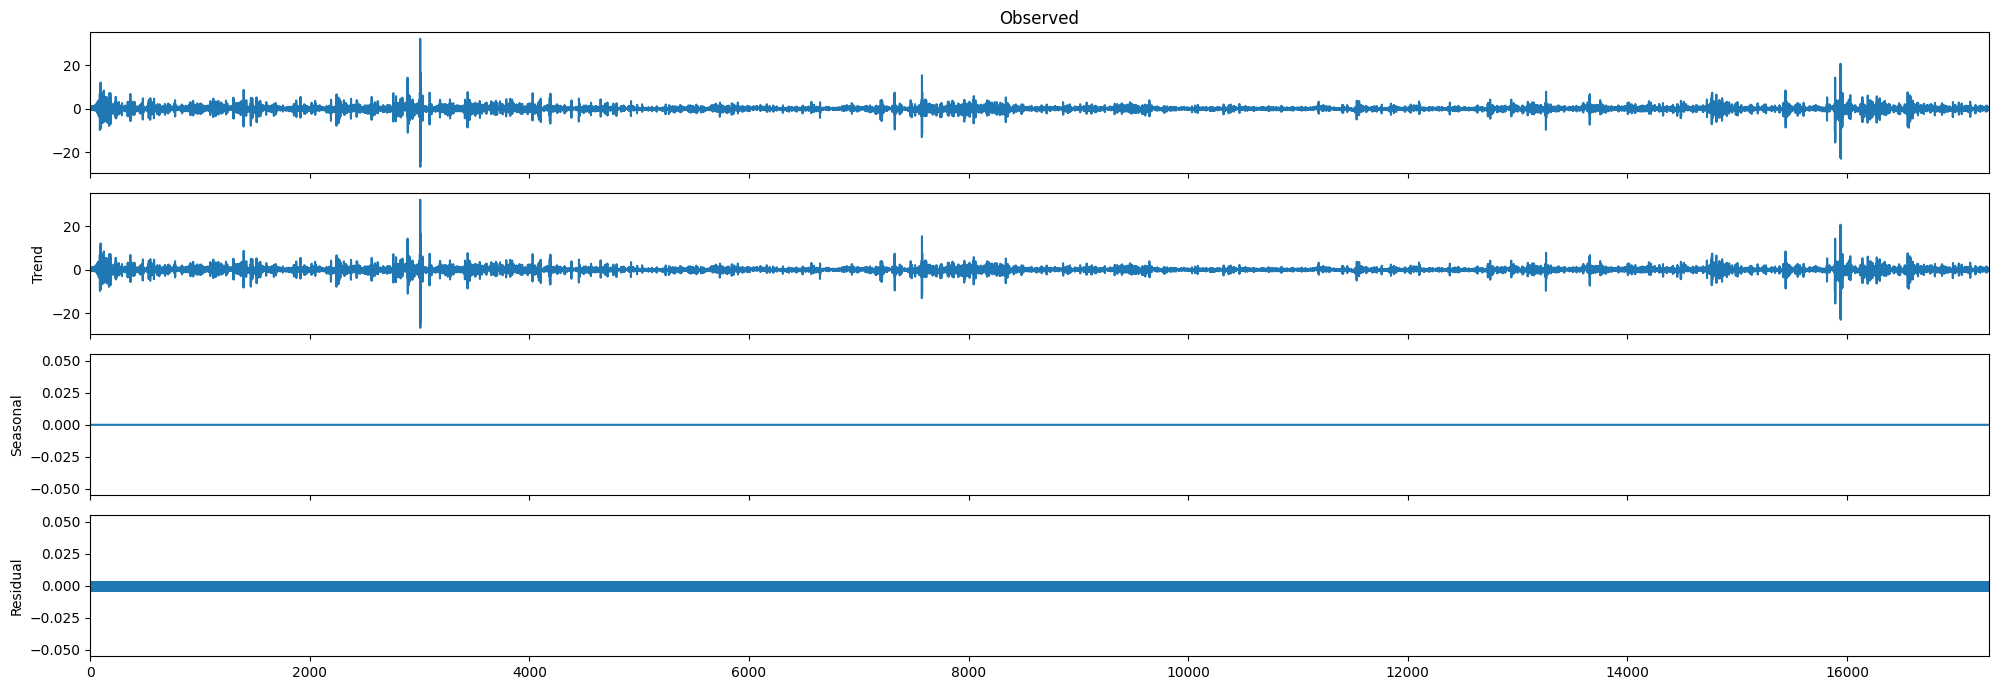

In [17]:
def sum_close(y, v):
    g = 1
    value = 0
    values = []
    v = v
    for i, row in enumerate(y):
        if g == v:
            value+=row
            values.append(value)
            value = 0
            g=1
        else:
            value+=row
            g+=1
    
    return values

v = 1
values = sum_close(y_rec, v)
d = seasonal_decompose(values, period=v)
d.plot()

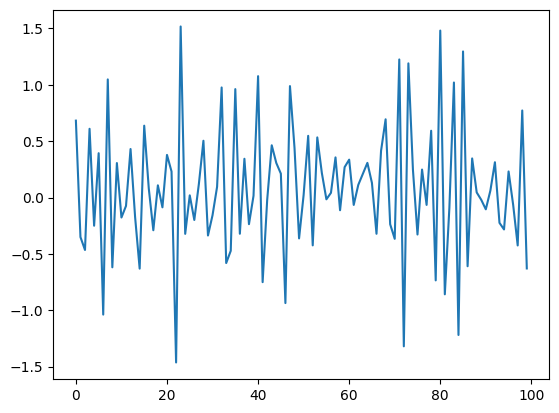

In [18]:
plt.plot(values[-100:])
#plt.plot(range(0, 100), dc[-100:]['price_change_percentage'])

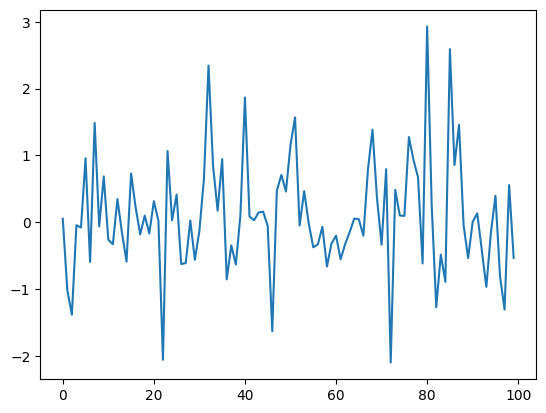

In [19]:
plt.plot(range(0, 100), dc[-100:]['price_change_percentage'])

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [43]:
dc.shape

(17292, 9)

In [256]:
dnnn = dc
n_input = 1
n_featues = dnnn.shape[1]
generator = TimeseriesGenerator(dnnn.values, dc['price_change_percentage'].values, length=n_input, batch_size=2048)

In [257]:
x, y = generator[0]
print(x.flatten())
print(y)

[0.08408139 1.         0.58910141 ... 2.         1.         2.        ]
[ 0.79114147 -0.45725986  0.15139787 ...  0.17985384  1.14156599
  5.3124539 ]


In [258]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [282]:
optimizer = Adam()

model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(n_input, n_featues)))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 300)               372000    
                                                                 
 dropout_15 (Dropout)        (None, 300)               0         
                                                                 
 dense_18 (Dense)            (None, 20)                6020      
                                                                 
 dropout_16 (Dropout)        (None, 20)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 21        
                                                                 
Total params: 378,041
Trainable params: 378,041
Non-trainable params: 0
_________________________________________________________________


In [283]:
model.fit(generator, epochs=100)

Epoch 1/100
9/9 [==============================] - 1s 67ms/step - loss: 8.4343
Epoch 2/100
9/9 [==============================] - 1s 66ms/step - loss: 4.8293
Epoch 3/100
9/9 [==============================] - 1s 75ms/step - loss: 3.5862
Epoch 4/100
9/9 [==============================] - 1s 63ms/step - loss: 3.4716
Epoch 5/100
9/9 [==============================] - 1s 64ms/step - loss: 3.2707
Epoch 6/100
9/9 [==============================] - 1s 66ms/step - loss: 3.1889
Epoch 7/100
9/9 [==============================] - 1s 63ms/step - loss: 3.1292
Epoch 8/100
9/9 [==============================] - 1s 63ms/step - loss: 3.1145
Epoch 9/100
9/9 [==============================] - 1s 65ms/step - loss: 3.0656
Epoch 10/100
9/9 [==============================] - 1s 65ms/step - loss: 3.0476
Epoch 11/100
9/9 [==============================] - 1s 68ms/step - loss: 2.9993
Epoch 12/100
9/9 [==============================] - 1s 65ms/step - loss: 2.9857
Epoch 13/100
9/9 [==============================]

KeyboardInterrupt: 

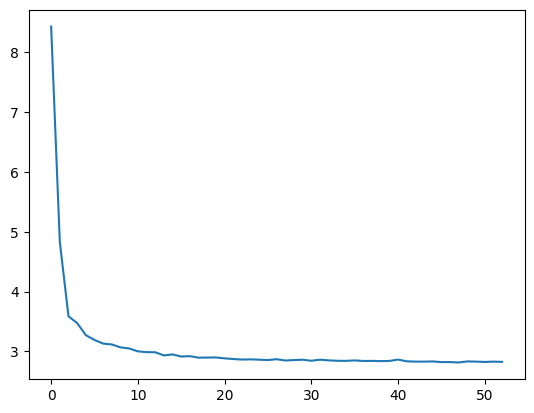

In [284]:
loss_history = model.history.history['loss']
plt.plot(range(len(loss_history)), loss_history)

17292


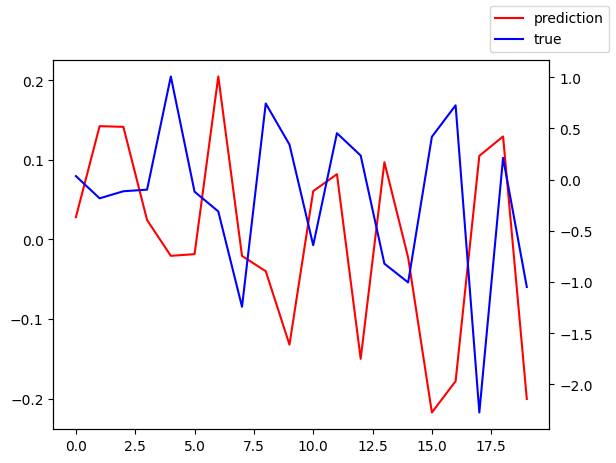

In [294]:
predictions = []
true_values = []
print(len(values))

daf = dc

episodes = 20

r = random.randint(0, daf.shape[0])
while r - episodes > episodes:
    r = random.randint(0, daf.shape[0])
    
data = daf.iloc[r:]
data = data
true_data = daf.iloc[r:]['price_change_percentage']

for i in range(0, episodes):
    e = data.iloc[i:n_input+i].to_numpy().reshape((1, n_input, n_featues))
    pred = model.predict(e, verbose=0)[0]
    
    predictions.append(pred)
    true_values.append(true_data.iloc[n_input+i+1])    
    
fig, ax_left = plt.subplots()
ax_left.plot(range(0, len(predictions)), predictions, label='prediction', color='r')
ax_right = ax_left.twinx()
ax_right.plot(range(0, len(true_values)), true_values, label='true', color='b')
fig.legend()

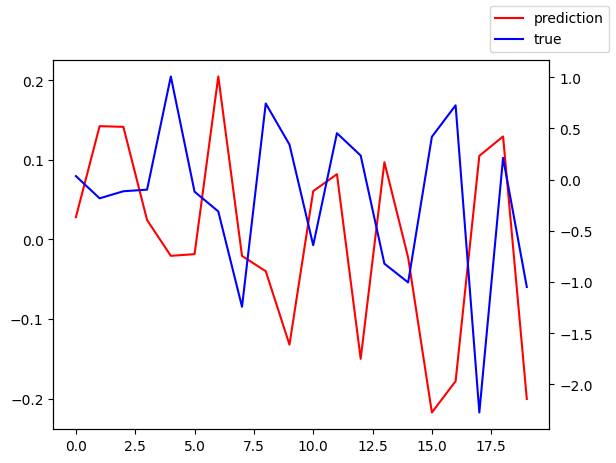

In [295]:
fig, ax_left = plt.subplots()
ax_left.plot(range(0, len(predictions)), predictions, label='prediction', color='r')
ax_right = ax_left.twinx()
ax_right.plot(range(0, len(true_values)), true_data.iloc[n_input+1:episodes+n_input+1], label='true', color='b')
fig.legend()

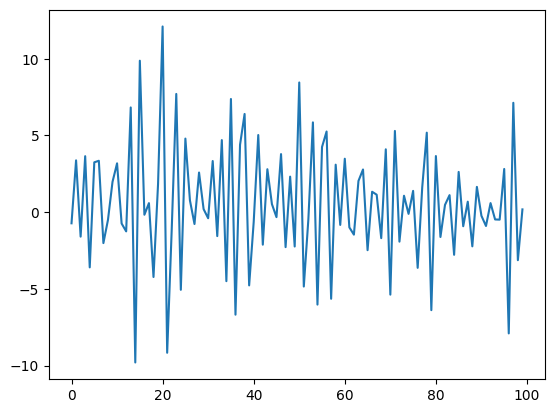

In [242]:
jik = sum_close(pcp['price_change_percentage'].to_numpy(), 24)
#plt.plot(jik[r:r+episodes])
plt.plot(values[r:r+episodes])

In [273]:
rat = 0
rat_2 = 0
true = []
pred = []
f = 0

for i in range(0, len(predictions)):
    if true_values[i] > rat:
        true.append(1)
    else:
        true.append(-1)
    if predictions[i] > rat_2:
        pred.append(1)
    else:
        pred.append(-1)
    rat = true_values[i]
    rat_2 = predictions[i]

for i in range(0, len(pred)):
    if pred[i] == true[i]:
        f+=1
        
print('Accuracy:', f/len(pred)) 

Accuracy: 0.522


In [276]:
rat = 0
rat_2 = 0
true = []
pred = []
f = 0
true_close_values = true_data.iloc[n_input+1:episodes+n_input+1].values

for i in range(0, len(predictions)):
    if true_close_values[i] > rat:
        true.append(1)
    else:
        true.append(-1)
    if predictions[i] > rat_2:
        pred.append(1)
    else:
        pred.append(-1)
    rat = true_close_values[i]
    rat_2 = predictions[i]

for i in range(0, len(pred)):
    if pred[i] == true[i]:
        f+=1
        
print('Accuracy:', f/len(pred)) 

Accuracy: 0.532


In [115]:
class TradingEnv(Env):
    def __init__(self, df, max_n_steps, window_size) -> None:
        super().__init__()        
        self.df = df
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df[0].shape[1]-1), dtype=np.float64)
        self.action_space = Discrete(len(Positions)-1)
        self.done = None
        
        self.current_step = 0
        self.max_n_steps = max_n_steps
        self.needed_space = self.window_size + self.max_n_steps
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0 + self.window_size + 3, self.df[self.random_df].value_counts().sum() - self.needed_space-13)
        
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.current_supertrend = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['supertrend']
        self.previous_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-2]['close']
        self.swing_high = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sh_nums']
        self.swing_low = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sl_nums']
        self.last_binary_indicators = self.df[self.random_df].drop(columns={'close', 'close_binary'}).iloc[self.random_index+self.window_size+self.current_step-1].values
        
        self.positions = []
        self.current_pos = None
        self.amount_of_positions_taken = 0
        self.held_price = 0
        self.in_a_pos = False
        
        self.trading_positions = 0
        self.profited_trading_positions = 0
        
        self.portfolio = 1
        
        self.stop_loss_value = 0
        self.take_profit_value = 0
        self.position_swing_low = 0
        self.position_swing_high = 0
        
        self.done_searching_swing_low = False
        self.done_searching_swing_high = False
        self.done_assigning_stop_loss_and_take_profit = False
        
        self.done_with_position = False
        
    def step(self, action):
        reward = 0
        done = False
        info = {'t': 0, 'p': 0}
        
        while not self.done_with_position:
            self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
            self.previous_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-2]['close']
            self.current_supertrend = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['supertrend']
            self.swing_high = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sh_nums']
            self.swing_low = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sl_nums']
            self.last_binary_indicators = self.df[self.random_df].drop(columns={'close', 'close_binary'}).iloc[self.random_index+self.window_size+self.current_step-1].values
            
            if self.in_a_pos:
                action = Positions.HOLD
                
            #if action != self.current_supertrend and not self.in_a_pos:
                #action = Positions.HOLD
                    
            if action != Positions.HOLD:
                self.current_pos = action
                self.amount_of_positions_taken+=1
                self.held_price = self.final_value
                self.in_a_pos = True
                self.done_searching_swing_low = False
                self.done_searching_swing_high = False
                self.done_assigning_stop_loss_and_take_profit = False
                
            if self.held_price == 0:
                #print("Invalid trade")
                self.current_step += 1
                if self.current_step >= self.max_n_steps:
                    #print("Done")
                    done = True
                else:
                    done = False
                reward = 0
                info = {'t': 0, 'p': 0}
                self.positions.append(action)
                self.done_with_position = True
                break
            
            if action == Positions.HOLD and not self.in_a_pos:
                #print("Hold position skip")
                self.current_step += 1
                if self.current_step >= self.max_n_steps:
                    #print("Done")
                    done = True
                else:
                    done = False
                reward = 0
                info = {'t': 0, 'p': 0}
                self.positions.append(action)
                self.done_with_position = True
                break 
            
            reward, p, t, take_profit = self.calculate_reward(action)
            
            if take_profit:
                #print("Done")
                self.positions.append(Positions.TAKE)
                self.done_with_position = True
            else:
                self.positions.append(action)  
            
            self.current_step += 1
            if self.current_step >= self.max_n_steps:
                #print("Done")
                done = True
                self.done_with_position = True
            else:
                done = False
            
            if not self.done_with_position:    
                observation = self.get_observation()
                
            info = {'p': p, 't': t}
           
        #print("Current step:", self.current_step)
        self.done_with_position = False
        observation = self.get_observation()
        return observation, reward, done, info
        
    def reset(self):
        self.done_with_position = False
        self.current_step = 0
        next_observation = self.get_observation(is_random=True)
        self.random_df = random.randint(0, len(self.df) - 1)
        self.random_index = random.randint(0 + self.window_size + 3, self.df[self.random_df].value_counts().sum() - self.needed_space-13)
        self.done = False
        self.positions.clear()
        self.final_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.previous_value = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-2]['close']
        self.current_supertrend = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['supertrend']
        self.swing_high = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sh_nums']
        self.swing_low = self.df[self.random_df].iloc[self.random_index+self.window_size+self.current_step-1]['sl_nums']
        self.last_binary_indicators = self.df[self.random_df].drop(columns={'close', 'close_binary'}).iloc[self.random_index+self.window_size+self.current_step-1].values
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        self.trading_positions = 0
        self.profited_trading_positions = 0
        self.portfolio = 1
        self.amount_of_positions_taken = 0
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_df = random.randint(0, len(self.df) - 1)
            self.random_index = random.randint(0 + self.window_size + 3, self.df[self.random_df].value_counts().sum() - self.needed_space-13)
        observationn = np.float64(self.df[self.random_df].iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].drop('close', axis=1).values)
        if observationn.shape[0] == 12:
            print(self.random_index)
            print(self.current_step)
        return observationn
    
    def final_render(self):
        final_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        sh_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['sh_nums']
        sl_observation = self.df[self.random_df].iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['sl_nums']
        
        #winrate = round(self.profited_trading_positions / self.trading_positions, 5)
            
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        take_signal = [True if self.positions[n]==Positions.TAKE else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        take_signal.append(False)
        
        plt.figure(figsize=(30,10))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=6, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.plot(final_observation, 'x', markersize=15, color='m', label = 'Take signal', markevery = take_signal)
        plt.plot(sh_observation, color='r', lw=2.)
        plt.plot(sl_observation, color='g', lw=2.)
        plt.plot()
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [116]:
class Trading(TradingEnv):
    def __init__(self, df, max_n_steps, window_size) -> None:
        super().__init__(df, max_n_steps, window_size)
        
    def calculate_reward(self, action):
        reward = 0
        percentage = 0.
        total_profit = 0
        amount_to_use = 0.05
        #indicator_monitor_reward = 0.07 * ((self.last_binary_indicators == action).sum())
        #reward = indicator_monitor_reward
        trade_done = False
        take_profit = False
        
        if self.current_pos == Positions.LONG:
            while not self.done_searching_swing_low:
                self.position_swing_low = self.swing_low
                self.done_searching_swing_low = True
                    
            if self.done_assigning_stop_loss_and_take_profit == False:
                self.stop_loss_value = self.position_swing_low
                self.take_profit_value = self.held_price + (self.held_price - self.position_swing_low) * 0.5
                self.done_assigning_stop_loss_and_take_profit = True

            if self.swing_low > self.position_swing_low:
                self.stop_loss_value = self.swing_low
            
            if self.final_value > self.take_profit_value:
                trade_done = True # take
            if self.final_value < self.stop_loss_value:
                trade_done = True # stop sell
                
        if self.current_pos == Positions.SHORT:
            while not self.done_searching_swing_high:
                self.position_swing_high = self.swing_high
                self.done_searching_swing_high = True
                    
            if not self.done_assigning_stop_loss_and_take_profit:
                self.stop_loss_value = self.position_swing_high
                self.take_profit_value = self.held_price - (self.position_swing_high - self.held_price) * 0.5
                self.done_assigning_stop_loss_and_take_profit = True
            
            if self.swing_high < self.position_swing_high:
                self.stop_loss_value = self.swing_high
            
            if self.final_value < self.take_profit_value:
                trade_done = True # take
            if self.final_value > self.stop_loss_value:
                trade_done = True # stop sell
        
        if self.in_a_pos and trade_done:
            percentage = calculate_percentage_increase(self.final_value, self.held_price)
            if self.current_pos == Positions.SHORT:
                percentage = -percentage
                
            total_profit += ((self.portfolio * amount_to_use) * percentage)
            portfolio_change = self.portfolio + ((self.portfolio * amount_to_use) * percentage)
            self.portfolio = portfolio_change
            
            self.trading_positions+=1
            if reward > 0:
                self.profited_trading_positions+=1
            
            reward = total_profit
            
            if reward < 0:
                reward *= 1
            
            #Reseting variables
            self.in_a_pos = False
            self.done_searching_swing_low = False
            self.done_searching_swing_high = False
            self.done_assigning_stop_loss_and_take_profit = False
            take_profit = True
            self.position_swing_low = 0
            self.position_swing_high = 0
            self.current_pos = None
            #print("Current step:", self.current_step)
            
        return reward, percentage, total_profit, take_profit

In [197]:
env = Trading(testing_data, window_size=13, max_n_steps=200)
env = Monitor(env)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


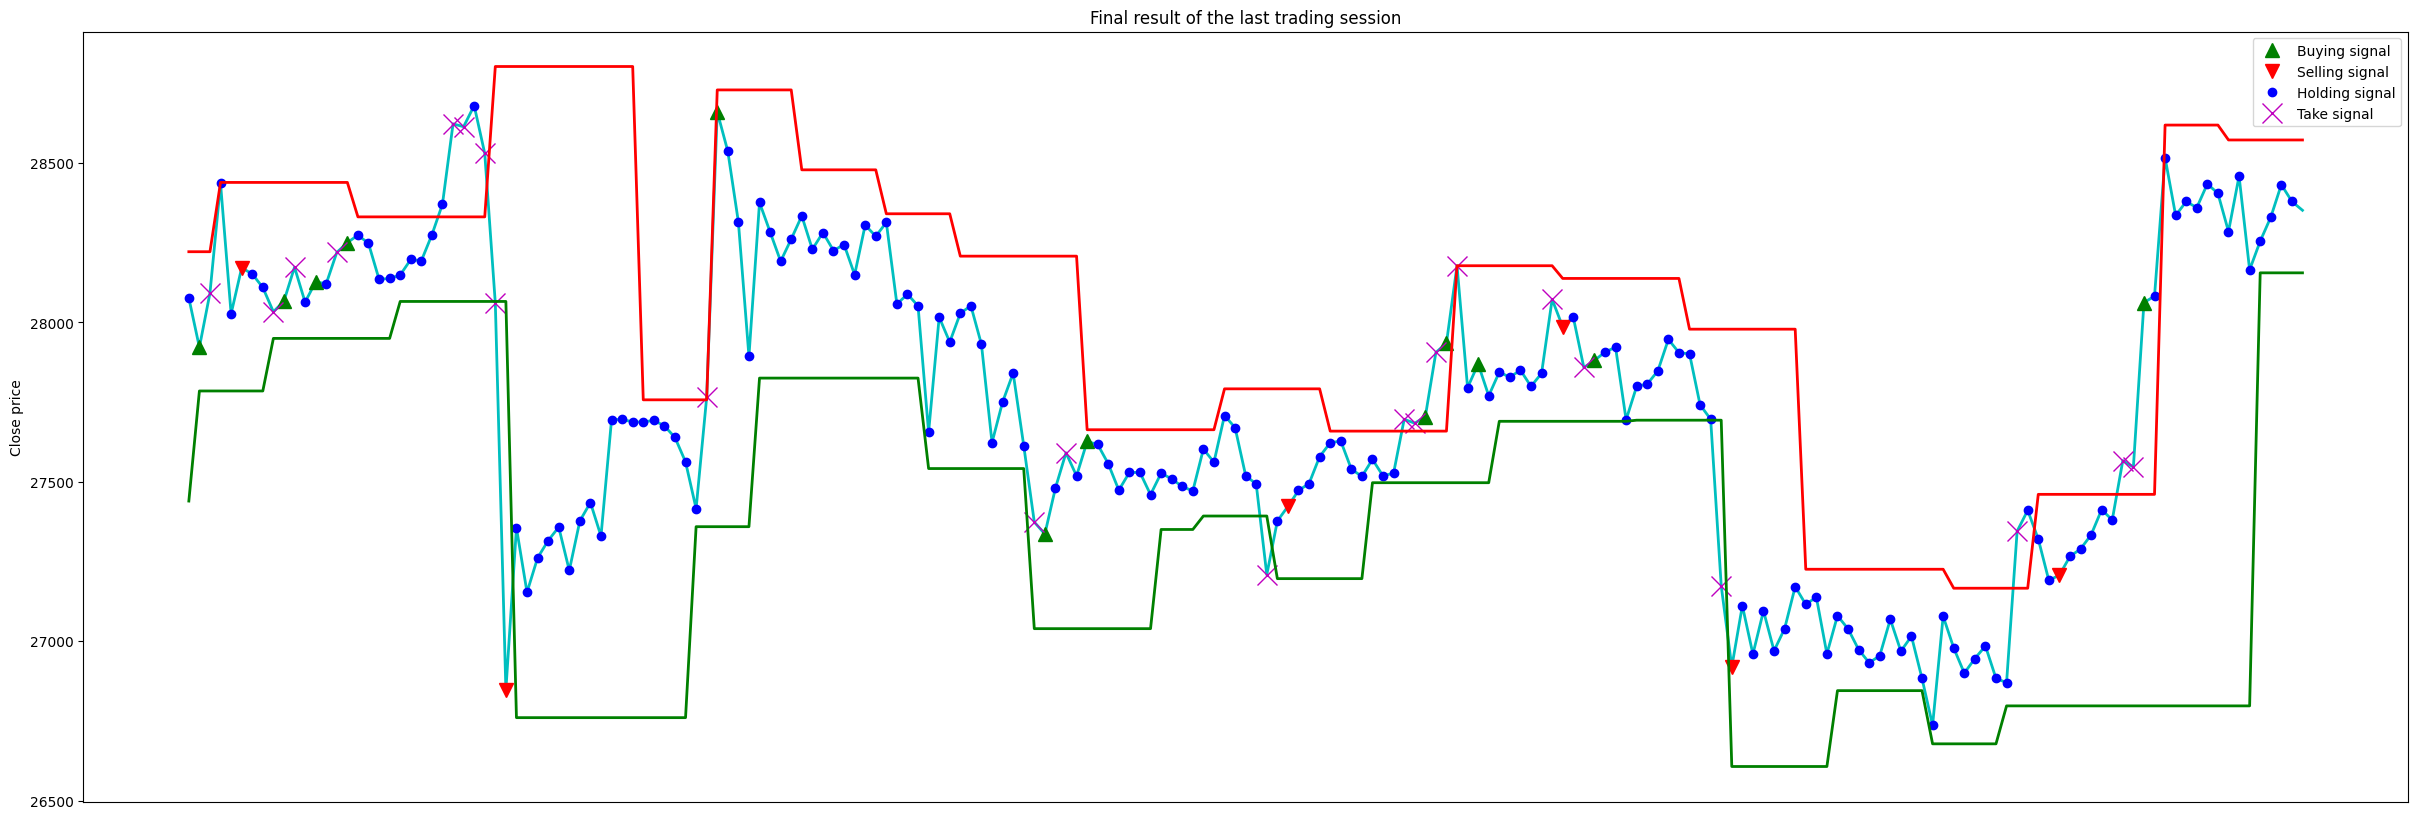

23
episode - 1 || score - -0.4070972286108133
-0.4070972286108133


In [198]:
episodes = 1
for n in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    ss = 0
    total_profit_ = 0
    while not done:
        action = env.action_space.sample()
        #print("Action", action)
        obs, reward, done, info = env.step(action)
        score += reward
        #print("REWARD", reward)
        #print('TOTAL_PROFIT', info['t'])
        #print('PERCENTAGE', info['p'])
        #print('INDICATOR_REWARD', info['i'])
        #print("Accumulated inc:", env.accumulated_percentage_increase)
        total_profit_ += info["t"]
    env.final_render()
    print(env.amount_of_positions_taken)
    print(f"episode - {n} || score - {score}")
    print(total_profit_)
    print('=' * 40)

In [176]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"
OPT_DIR = "./opt/"

In [177]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [223]:
def optimize_ppo(trial):
    return {
        "n_steps": trial.suggest_int("n_steps", 64, 8192),
        "gamma": trial.suggest_loguniform("gamma", 0.8, 0.9999),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-6, 1e-4),
        "clip_range": trial.suggest_uniform("clip_range", 0.1, 0.4),
        "gae_lambda": trial.suggest_uniform("gae_lambda", 0.8, 0.99),
        "ent_coef": trial.suggest_uniform("ent_coef", 0.001, 0.01),
    }

In [224]:
def optimize_agent(trial):
    try:
        model_params=optimize_ppo(trial)
        env = Trading(df, window_size=90, n_steps=100)
        
        model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, **model_params)
        model.learn(100000)
        
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    except Exception as e:
        return -1000

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_agent, n_trials=35, n_jobs=1)

In [ ]:
study.best_params

{'n_steps': 7917,
 'gamma': 0.8148319613766952,
 'learning_rate': 1.1494222672968137e-05,
 'clip_range': 0.11454224768088915,
 'gae_lambda': 0.9747187305774679,
 'ent_coef': 0.007806731954039324}

In [458]:
model = RecurrentPPO(
    "MlpLstmPolicy",
    env,
    verbose=0,
    tensorboard_log=LOG_DIR,
    n_steps=8192,
    gamma=0.8148319613766952,
    gae_lambda=0.9747187305774679,
    ent_coef=0.007806731954039324,
)

In [178]:
model = PPO(
    "MlpPolicy",
    env,
    verbose=0,
    tensorboard_log=LOG_DIR,
    n_steps=8192,
    gamma=0.8148319613766952,
    gae_lambda=0.9747187305774679,
    ent_coef=0.007806731954039324,
)

In [122]:
model = DQN(
    "MlpPolicy",
    env=env, verbose=0, 
    tensorboard_log=LOG_DIR,
    batch_size=8192, 
    learning_rate=0.004, 
    learning_starts=300000,
    gamma=0.9, 
    exploration_fraction=0.5)

In [ ]:
loaded_model = RecurrentPPO.load("./saved_models/best_model_500000", env=env)

In [ ]:
loaded_model = DQN.load("./saved_models/best_model_1000000", env=env)

In [199]:
loaded_model = PPO.load("./saved_models/best_model_1000000", env=env)

In [ ]:
opt_model = RecurrentPPO.load("./saved_models/opt_model_training_1", env=env)

In [179]:
model.learn(total_timesteps=1000000, callback=callback)

In [188]:
def test_portfolio(model, starting_money, amount_to_use, total_episodes_to_run = 1):
    all_portfolio_accumulation_results = []
    all_final_portfolio_value = []
    all_score = []
    win = 0
    
    for episode in range(1, total_episodes_to_run+1):
        obs = env.reset()
        done = False
        score = 0
        portfolio = starting_money
        portfolio_accumulation_results = []
        percentage_increase = 0
        total_profit = 0
    
        while not done:
            action, lstm_cells = model.predict(obs)
            obs, reward, done, info = env.step(action)
            score += reward
            percentage_increase = info['p']
        
            total_profit += ((portfolio * amount_to_use) * percentage_increase)
            portfolio_change = portfolio + ((starting_money * amount_to_use) * percentage_increase)
            portfolio = portfolio_change
            portfolio_accumulation_results.append(portfolio_change)
        
        all_portfolio_accumulation_results.append(portfolio_accumulation_results)
        all_final_portfolio_value.append(portfolio)
        all_score.append(score)
        if total_profit > 0:
            win += 1
    
    if total_episodes_to_run < 100:        
        fig, ax = plt.subplots()
        fig.set_size_inches(20, 7)
        for i in range(0, len(all_portfolio_accumulation_results)):
            ax.plot(all_portfolio_accumulation_results[i])
        env.final_render()
    
    print(f'avg score - {np.average(all_score)}')
    print(f'avg final portfolio value - {np.average(all_final_portfolio_value)}')
    print(f'winrate - {win / total_episodes_to_run}')

In [202]:
test_portfolio(loaded_model, starting_money=10000, amount_to_use=0.05, total_episodes_to_run=3000)

avg score - 0.14813220754447215
avg final portfolio value - 11303.442464274849
winrate - 0.5923333333333334
